Code to simulate generalised rock-paper-scissors games on networks of varying incoherence 

In [1]:
using LightGraphs, GraphIO, GraphPlot, NetworkDynamics, OrdinaryDiffEq, Plots, LightGraphs, Printf, SparseArrays

In [2]:
using LinearAlgebra, IterativeSolvers, Statistics
#Function which calculates Trophic Level


function get_levels(A)
    
    A= convert(Array{Float64}, A)
    
    w_in = vec(sum(A, dims=1))
   
    w_out= vec(sum(A, dims=2))
    
   
    
    u = w_in + w_out 
    
    v= w_in - w_out 
   
    Lambda=  diagm(u)-  A - transpose(A)
    
   
    Lambda[1,1]= 0 
    
    h= bicgstabl(Lambda, v, 10)
    #h=  lsmr(Lambda, v)   
    #h= Lambda \ v   
    h= h .- minimum(h)
    
    return h
end

get_levels (generic function with 1 method)

In [3]:
#Function to calculate Trophic Incohrence 


function calc_troph_incoh(A,h)
    
    F=0

    for (x,y,v) in zip(findnz(A)...)
  
    
        F = F + v*(h[y] - h[x] -1 )^2
        
    end
    
    F= F/sum(A)
    
end
    
    
    
    

calc_troph_incoh (generic function with 1 method)

In [4]:
g1 = path_digraph(5)

g2 = cycle_digraph(5)

{5, 5} directed simple Int64 graph

In [5]:
g = g1

{5, 4} directed simple Int64 graph

In [6]:
function update_game(M,g,N,grid, mu)
    options= [[0,1], [1,0],[-1,0],[0,-1]]
    
    for a in 1:grid
        
        pick = rand(1:(grid), 2,1)
        
        
        strat = M[(pick[1]),(pick[2] ) ]
            
        pick2= rand(1:4)
            
        neighbour = (pick + options[pick2]).%(grid ) 
        
        for b in 1:2
            if neighbour[b]==0
                
                neighbour[b]= grid
                
            end
        end
        
        strat_neighbour = M[neighbour[1],neighbour[2]]    
            
         
        in_connections= inneighbors(g,strat)
        
        if strat == strat_neighbour
        
        elseif strat_neighbour in in_connections
          
            M[pick[1],pick[2]] = strat_neighbour
        
            
         else 
            rand_mu= rand()
            
            if rand_mu>mu
                M[pick[1],pick[2]] = strat_neighbour
                M[neighbour[1],neighbour[2]] = strat
            end
        end
        
        
        end
        
        
    end

update_game (generic function with 1 method)

In [7]:
function update_game_comp(M,g,N,grid)
    
    
    for a in 1:grid
        
        pick = rand(1:(grid), 2,1)
        
        
        strat = M[(pick[1]),(pick[2] ) ]
            
        pick2= rand(1:(grid), 2,1)
        
        
        #neighbour = M[(pick2[1]),(pick2[2] ) ]
        
       
           

        
        #strat_neighbour = M[neighbour[1],neighbour[2]]    
         strat_neighbour= M[(pick2[1]),(pick2[2] ) ]
          
        in_connections= inneighbors(g,strat)
        
        if strat == strat_neighbour
        
        elseif strat_neighbour in in_connections
          
            M[pick[1],pick[2]] = strat_neighbour
        
            
         
        end
        
        
        end
        
        
    end

update_game_comp (generic function with 1 method)

In [8]:
#Function to update the system and measure data


function update_game_data(M,g,N,grid)
    
    
    for a in 1:grid
        
        pick = rand(1:(grid))
        
        
        strat = M[pick ]
            
        pick2= rand(1:(grid))
        
        
        #neighbour = M[(pick2[1]),(pick2[2] ) ]
        
       
           

        
        #strat_neighbour = M[neighbour[1],neighbour[2]]    
         strat_neighbour= M[pick2]
          
        in_connections= inneighbors(g,strat)
        #in_connections= outneighbors(g,strat)
        
        if strat == strat_neighbour
        
        elseif strat_neighbour in in_connections
          
            M[pick] = strat_neighbour
        
            
         
        end
        
        
        end
        
        
    end

update_game_data (generic function with 1 method)

In [9]:
N=nv(g)
grid = 100
M =  rand(1:N, grid)

mu =1.0


1.0

In [56]:
using StatsBase

#Seting up game parameters where grid is number of players 
attempts = 1000
N=100
grid = 1000

#Range of T control paramater can be linear or log 

#T_list= LinRange(0.025, 8, number)

T_list= 10 .^ (range(-2,stop=2,length=attempts))
B=0

#Set the edge number 
L_targ = 5*N
#T_list= [1000000]
#T_list= 10000*ones(attempts)

stop= 2*N^2

#g= random_tournament_digraph(50)
#g= erdos_renyi(50, 2*50, is_directed=true)
#g = path_digraph(50)
#g= cycle_digraph(5)
#g = watts_strogatz(50, 4, 0.2, is_directed = true)
#g= barabasi_albert(50, 5, 3, is_directed=true)
#g = path_digraph(5)
#g=g3

#Setting intial strategies
mat= rand(1:N, grid)


#Data lists 
F_list = zeros(0)

ent_list = zeros(0)

var_t_list = zeros(0)


var_pr_list = zeros(0)

var_d_list = zeros(0)

var_diff_list = zeros(0)


mean_t_list = zeros(0)


mean_pr_list = zeros(0)

mean_d_list = zeros(0)

mean_diff_list = zeros(0)



ranks = collect(1:N)

survivors = zeros(N)
survivors_pagerank = zeros(N)

survivors_degree = zeros(N)

survivors_actual = zeros(N)
survivors_pagerank_actual = zeros(N)

survivors_degree_actual = zeros(N)


survivors_diff =zeros(N)

survivors_diff_actual=zeros(N)

no_left = zeros(attempts)

mes_time=100

winner_t = 0
winner_p = 0
winner_d = 0
winner_diff = 0

for n in 1:attempts
    
    println(n*100/attempts)
    
    g = SimpleDiGraph(N)
    
    #create intial graphs 
    for i in (1+B):N
        
        pick = rand(B+1:N)
        
        add_edge!(g, pick, i)
        
        
        end 
    A = (adjacency_matrix(g))
    
    L=sum(A)
    
    h = get_levels(A)
    

    
    
    edgelist= Int[]
    
    problist= zeros(0)
    
    edge_start= zeros(Int64,0)
    
    edge_end = zeros(Int64, 0)
    
    #Create list of edge probalities 
    for i in 1:N
        
        for j in (B+1):N
            
            if A[i,j]!=1 && i!=j
                #Fix Array indexing here doesn't make sense. Need 2d array
                append!( edgelist, [i,j] )
                append!( edge_start, i )
                append!(edge_end, j )
                
                prob = exp(-((h[j]-h[i] -1)^2)/T_list[n]/2) + 0.00000000000001
                
                
                
                append!( problist, prob )
            end
            
            
            
            end
        
            end 
    
    prob_sum = sum(problist)
    
    loop_size= size(problist, 1)
    
    
    
    #More efficently sampling the edge probablities 
        
    count=0
    
    #println(edgelist[500])
    
    while (-L + L_targ)>0
        
        count = count + 1 
        
        prob_sum = sum(problist)
        
        random = prob_sum*(rand())
        
        
        z=0
        
        #println(prob_sum)
        for k in 1:loop_size
            
            z= z + problist[k]
            
           
            if z>=random
               
                if A[edge_start[k],edge_end[k]]==0
                
                   A[edge_start[k],edge_end[k]]=1
                    
                   problist[k]=0 
                
                    L = L +1
                    
                    break
                       
                else 
                    
                    println("Missed")
                   
                    println(A[(edgelist[k])])
                    break
                   
              
                end     
            
            end
                end
            
            if (count-stop)>=0
            
                
                
            
                break
        
            
            
                end
        
    end
        
    
    
    
    
    #g= random_tournament_digraph(50)
    #g= erdos_renyi(50, 2*50, is_directed=true)
    #g = path_digraph(50)
    #g = cycle_digraph(5)
    #g =watts_strogatz(50, 4, 0.2, is_directed = true)
    #g= barabasi_albert(50, 10, 10, is_directed=true)
    #A = ((adjacency_matrix(g)))
    
    g= SimpleDiGraph((A))
    N=nv(g)
    #println(sum(A)/N)
    h = get_levels(A)
    
    F= calc_troph_incoh(A,h)    
    append!( F_list, F )  
    
   
    mat= rand(1:N, grid)
    
    #Update game and measure the stragtey probablities for all the centralities 
    
    for b in 1:4000
    update_game_data(mat,g,N,grid)
    end
    
    pg = reverse(sortperm(pagerank(reverse(g), 0.85, 100, 1.0e-6)))
    pd = sortperm(degree_centrality(g))
    p = sortperm(h)
    p_diff= (sortperm(indegree_centrality(g)- outdegree_centrality(g) ))
    
    
    prob_trophic_network = zeros(N)
        

    prob_pagerank_network = zeros(N)

    prob_degree_network = zeros(N)

    prob_degree_diff_network = zeros(N)
        
    
    
    
    ent= 0
    
    for c in 1:mes_time
    
    update_game_data(mat,g,N,grid)  
    
    strats_left = unique(mat)
    
    actual_left = countmap(mat)
        
    no_left[n] = size(strats_left)[1] + no_left[n]
    
    for g in 1:size(strats_left)[1]
            
            p_i = 1/collect(values(actual_left))[g]
            ent = p_i*log(p_i) + ent
    
        end
        
   
    
    #print(pg -p)
        
        
    for b in 1:10
        

   if p[b] in strats_left 
            
     #println(p[1])
    #println((collect(keys(actual_left)))[argmax(collect(values(actual_left)))])       
            
    if p[b]== (collect(keys(actual_left)))[argmax(collect(values(actual_left)))]
            
            #println(maximum(values(actual_left))
            #if [p[1]] == maximum(values(actual_left))
            winner_t = winner_t + 1
        end
        end
        
     
   if pg[b] in strats_left 
            
     #println(p[1])
    #println((collect(keys(actual_left)))[argmax(collect(values(actual_left)))])       
            
    if pg[b]== (collect(keys(actual_left)))[argmax(collect(values(actual_left)))]
            
            #println(maximum(values(actual_left))
            #if [p[1]] == maximum(values(actual_left))
            winner_p = winner_p + 1
        end
        end   
        
        
        
     if pd[b] in strats_left 
            
     #println(p[1])
    #println((collect(keys(actual_left)))[argmax(collect(values(actual_left)))])       
            
    if pd[b]== (collect(keys(actual_left)))[argmax(collect(values(actual_left)))]
            
            #println(maximum(values(actual_left))
            #if [p[1]] == maximum(values(actual_left))
            winner_d = winner_d + 1
        end
        end   
       
      if p_diff[b] in strats_left   
        
      if p_diff[b]== (collect(keys(actual_left)))[argmax(collect(values(actual_left)))]
            
            #println(maximum(values(actual_left))
            #if [p[1]] == maximum(values(actual_left))
            winner_diff = winner_diff + 1
        end
        end         
            
  
            end 
        
        
    for a in 1:N
        
        if p[a] in strats_left
            
            survivors[a]= survivors[a] + 1
            
            survivors_actual[a]= survivors_actual[a] + actual_left[p[a]]
             
            prob_trophic_network[a] = prob_trophic_network[a] + actual_left[p[a]]
            
        end
        
        if pg[a] in strats_left
            
            survivors_pagerank[a]= survivors_pagerank[a] + 1
            
            survivors_pagerank_actual[a]= survivors_pagerank_actual[a] + actual_left[pg[a]]
                
            prob_pagerank_network[a] = prob_pagerank_network[a] + actual_left[pg[a]]
        end
        
        
        if pd[a] in strats_left
        
            survivors_degree[a]= survivors_degree[a] + 1
            
            survivors_degree_actual[a]= survivors_degree_actual[a] + actual_left[pd[a]]
                
                
            prob_degree_network[a] = prob_degree_network[a] + actual_left[pd[a]]
        end
            
            
          
        if p_diff[a] in strats_left
        
            survivors_diff[a]= survivors_diff[a] + 1
            
            survivors_diff_actual[a]= survivors_diff_actual[a] + actual_left[p_diff[a]]
                
                
            prob_degree_diff_network[a] = prob_degree_diff_network[a] + actual_left[p_diff[a]]
        end
               
            
            
    end
    end
    
    prob_trophic_network = prob_trophic_network/grid/mes_time

    prob_pagerank_network = prob_pagerank_network/grid/mes_time

    prob_degree_network = prob_degree_network/grid/mes_time

    prob_degree_diff_network = prob_degree_diff_network/grid/mes_time
    
    
    
    
    
    append!( var_t_list, var(prob_trophic_network) ) 
    
    append!( var_pr_list, var(prob_pagerank_network) ) 
    
    append!( var_d_list, var(prob_degree_network) ) 
    
    append!( var_diff_list, var(prob_degree_diff_network) )
    
    append!( mean_t_list, mean(prob_trophic_network) ) 
    
    append!( mean_pr_list, mean(prob_pagerank_network) ) 
    
    append!( mean_d_list, mean(prob_degree_network) ) 
    
    append!( mean_diff_list, mean(prob_degree_diff_network) ) 
    
    
     append!( ent_list, -ent/mes_time/N )
    
    
end

no_left = no_left/mes_time/N
F_average = mean(F_list)
println("Complete")


t_wins= winner_t/mes_time/attempts
pr_wins = winner_p/mes_time/attempts

d_wins= winner_d/mes_time/attempts

diff_wins = winner_diff/mes_time/attempts







println("Best Picked by Trophic = $t_wins")
println("Best Picked by PageRank = $pr_wins")
println("Best Picked by Degree = $d_wins")
println("Best Picked by Degree Difference = $diff_wins")

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
10.0
10.1
10.2
10.3
10.4
10.5
10.6
10.7
10.8
10.9
11.0
11.1
11.2
11.3
11.4
11.5
11.6
11.7
11.8
11.9
12.0
12.1
12.2
12.3
12.4
12.5
12.6
12.7
12.8
12.9
13.0
13.1
13.2
13.3
13.4
13.5
13.6
13.7
13.8
13.9
14.0
14.1
14.2
14.3
14.4
14.5
14.6
14.7
14.8
14.9
15.0
15.1
15.2
15.3
15.4
15.5
15.6
15.7
15.8
15.9
16.0
16.1
16.2
16.3
16.4
16.5
16.6
16.7
16.8
16.9
17.0
17.1
17.2
17.3
17.4
17.5
17.6
17.7
17.8
17.9
18.0
18.1
18.2
18.3
18.4
18.5
18.6
18.7
18.8
18.9
19.0
19.1
19.2
19.3
19.4
19.5
19.6
19.7
19.8
19.9
20.0
20.1
20.2
20.3
20.4
20.5
20.6
20.7
20.8
20.9
21.0
21.1
21.2
21.3
21.4
21.5
21.6
21.7
21.8
21.9
22.0

Data on different stragties and cumulative probalities data used in paper.

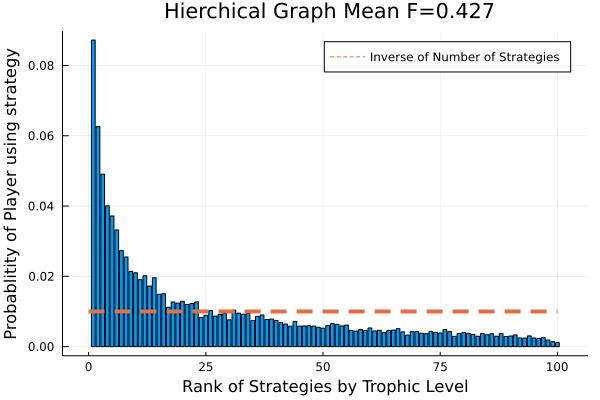

In [57]:
F_round = round(F_average, digits=3)


bar(ranks,survivors_actual/attempts/grid/mes_time, label=false, xlabel="Rank of Strategies by Trophic Level", ylabel="Probablitity of Player using strategy",
    title= " Hierchical Graph Mean F=$F_round")

line= LinRange(0, N, 1000)

yline = ones(1000)/N

plot!(line,yline, label= "Inverse of Number of Strategies" , lw =4, line =:dash, )

#savefig("Reversed_Player_Survival_probalities_Hierchical_larger_networks.pdf")

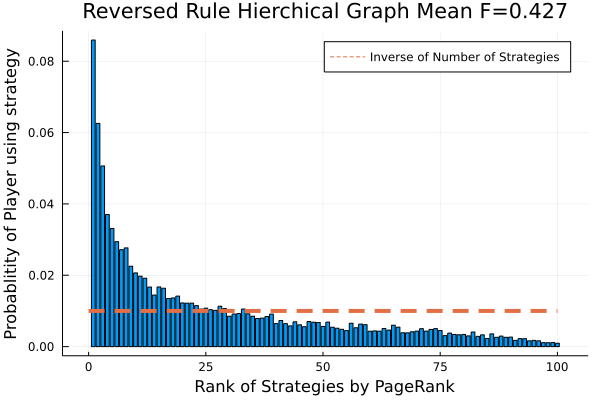

In [58]:
bar(ranks,survivors_pagerank_actual/attempts/grid/mes_time, label=false, xlabel="Rank of Strategies by PageRank", ylabel="Probablitity of Player using strategy",
    title= "Reversed Rule Hierchical Graph Mean F=$F_round", )

line= LinRange(0, N, 1000)

yline = ones(1000)/N

plot!(line,yline, label= "Inverse of Number of Strategies" , lw =4, line =:dash)

#savefig("Reversed_Player_Survival_probalities_Hierchical_larger_networks_PageRank.pdf")

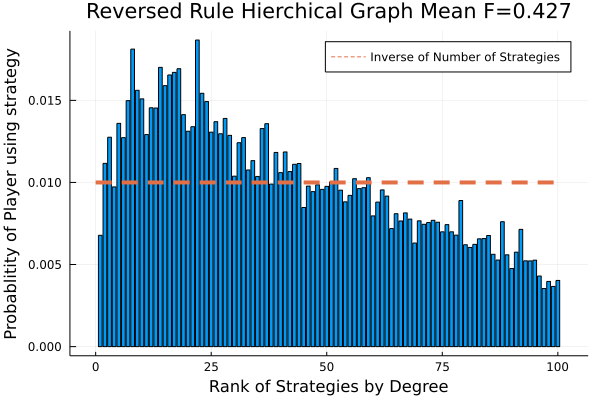

In [59]:
bar(ranks,survivors_degree_actual/attempts/grid/mes_time, label=false, xlabel="Rank of Strategies by Degree", ylabel="Probablitity of Player using strategy",
    title= "Reversed Rule Hierchical Graph Mean F=$F_round")

line= LinRange(0, N, 1000)

yline = ones(1000)/N

plot!(line,yline, label= "Inverse of Number of Strategies" , lw =4, line =:dash)

#savefig("Reversed_rule_Player_Survival_probalities_Hierchical_larger_networks_degree.pdf")

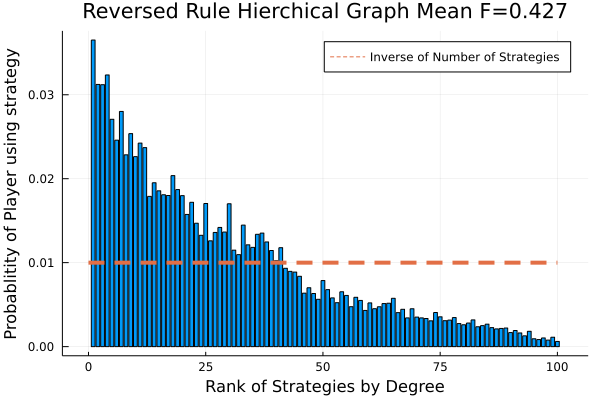

In [60]:
bar(ranks,survivors_diff_actual/attempts/grid/mes_time, label=false, xlabel="Rank of Strategies by Degree", ylabel="Probablitity of Player using strategy",
    title= "Reversed Rule Hierchical Graph Mean F=$F_round")

line= LinRange(0, N, 1000)

yline = ones(1000)/N

plot!(line,yline, label= "Inverse of Number of Strategies" , lw =4, line =:dash)

#savefig("Reversed_rule_Player_Survival_probalities_Hierchical_larger_networks_degree.pdf")

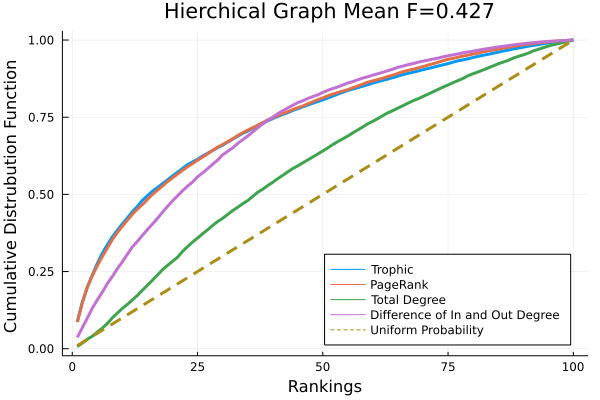

In [61]:
prob_trophic = survivors_actual/attempts/grid/mes_time

prob_pagerank = survivors_pagerank_actual/attempts/grid/mes_time

prob_degree = survivors_degree_actual/attempts/grid/mes_time

prob_degree_diff = survivors_diff_actual/attempts/grid/mes_time

cdf_trophic = zeros(N)

cdf_pr= zeros(N)

cdf_degree = zeros(N)

cdf_diff = zeros(N)

cdf_t_count = 0
cdf_p_count = 0

cdf_d_count = 0

cdf_diff_count =0

for i in 1:N
    
    cdf_t_count = cdf_t_count + prob_trophic[i]
    cdf_trophic[i] = cdf_t_count
    
    cdf_p_count = cdf_p_count + prob_pagerank[i]
    cdf_pr[i] = cdf_p_count
    
    
    cdf_d_count = cdf_d_count + prob_degree[i]
    cdf_degree[i] = cdf_d_count
    
    
    cdf_diff_count = cdf_diff_count + prob_degree_diff[i]
    cdf_diff[i] = cdf_diff_count
    
    end  
  

plot(ranks, cdf_trophic, legend=:bottomright, ylabel= "Cumulative Distrubution Function ", xlabel = "Rankings", label ="Trophic", lw=3, 
title= " Hierchical Graph Mean F=$F_round")
plot!(ranks, cdf_pr, label = "PageRank", lw=3, )
plot!(ranks, cdf_degree, label="Total Degree", lw=3)

plot!(ranks, cdf_diff, label="Difference of In and Out Degree", lw=3)
plot!(ranks,ranks/(size(ranks)[1]), label= "Uniform Probability", lw =3, line=:dash)
#savefig("New_CDF_Hierchical_high_F.pdf")

In [62]:
c_t = cdf_trophic[10]

c_pr= cdf_pr[10]


c_d = cdf_degree[10]


c_diff = cdf_diff[10]

println(  "Trophic CDF $c_t")

println(  "PageRank CDF $c_pr")

println(  "Degree CDF $c_d")

println(  "Degree Difference CDF $c_diff")






Trophic CDF 0.404611
PageRank CDF 0.396733
Degree CDF 0.13056600000000002
Degree Difference CDF 0.281842


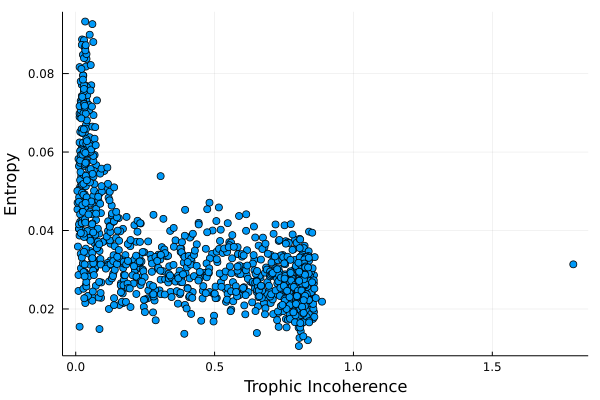

In [63]:
plot(F_list,ent_list, seriestype = :scatter, xlabel= "Trophic Incoherence", ylabel="Entropy", legend=:false)

#savefig("Entropy_test.pdf")


In [64]:
plot(F_list, (var_t_list), seriestype = :scatter, ylabel="Variance of Probablity", xlabel="Trophic Incoherence", label="Trophic", legend=:bottomright)

plot!(F_list, (var_pr_list), seriestype = :scatter, label="PageRank")

plot!(F_list, (var_d_list), seriestype = :scatter, label="Degree")

plot!(F_list, (var_diff_list), seriestype = :scatter, label="Degree Differences")



savefig("Network_variance_data.pdf")

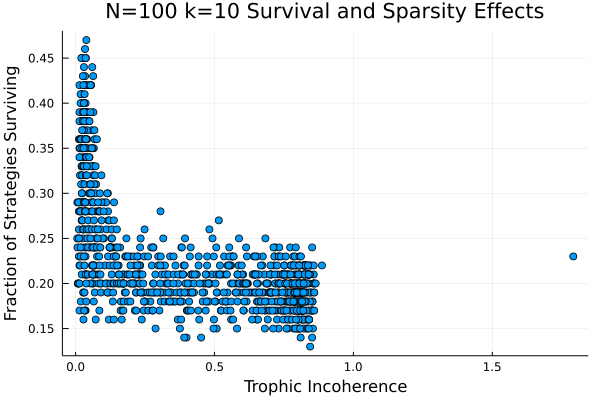

In [65]:
plot(F_list, no_left, seriestype = :scatter, ylabel="Fraction of Strategies Surviving", xlabel="Trophic Incoherence", 
title="N=100 k=10 Survival and Sparsity Effects",legend=:false)
#savefig("Sparsity_survival_effects.pdf")

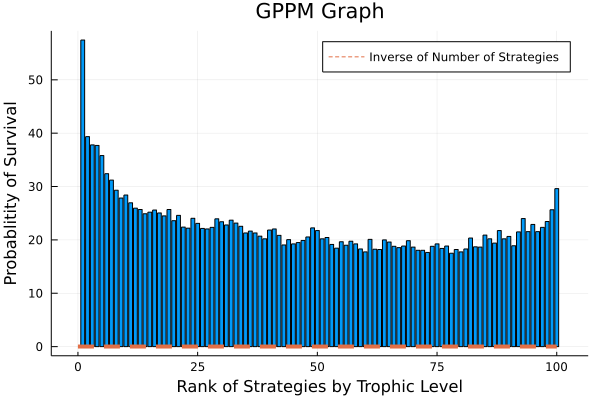

In [38]:
bar(ranks,survivors/attempts, label=false, xlabel="Rank of Strategies by Trophic Level", ylabel="Probablitity of Survival",
    title= "GPPM Graph")

line= LinRange(0, N, 1000)

yline = ones(1000)/N

plot!(line,yline, label= "Inverse of Number of Strategies" , lw =4, line =:dash)

#savefig("Survival_probalities_Path_50_Scale_Free_Pref_attach_tests_2.pdf")

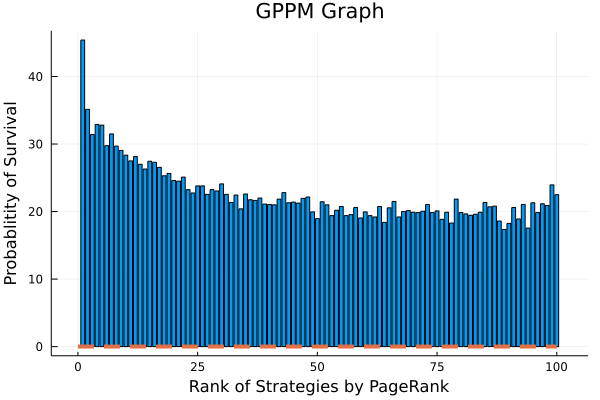

In [39]:
bar(ranks,survivors_pagerank/attempts, label=false, xlabel="Rank of Strategies by PageRank", ylabel="Probablitity of Survival",
    title= "GPPM Graph")

line= LinRange(0, N, 1000)

yline = ones(1000)/N

plot!(line,yline, label= "Inverse of Number of Strategies" , lw =4, line =:dash, legend = false)

#savefig("Survival_probalities_Path_50_Scale_Free_Pref_attach_tests_2.pdf")

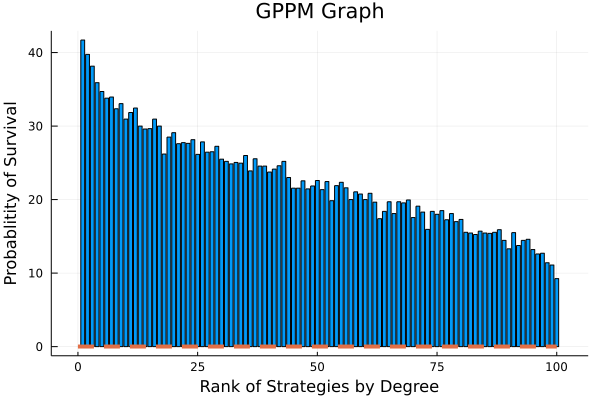

In [40]:
bar(ranks,survivors_degree/attempts, label=false, xlabel="Rank of Strategies by Degree", ylabel="Probablitity of Survival",
    title= "GPPM Graph")

line= LinRange(0, N, 1000)

yline = ones(1000)/N

plot!(line,yline, label= "Inverse of Number of Strategies" , lw =4, line =:dash, legend=false)


In [41]:
g= barabasi_albert(1000, (50), 3, is_directed=true)

A = (adjacency_matrix(g))


h = get_levels(A)

calc_troph_incoh(A,h)

0.23019503284758616

In [42]:
b = update_game(M,g,N,grid,mu)

M

LoadError: BoundsError: attempt to access 100-element Vector{Int64} at index [159, 257]

In [25]:
g3= path_digraph(5)

add_edge!(g3, 1, 3)




A = (adjacency_matrix(g3))


h = get_levels(A)

F =calc_troph_incoh(A,h)
println(h)

println(F)

[0.0, 0.6666666666669805, 1.3333333333334245, 2.333333333333303, 3.3333333333333486]
0.06666666666666668


In [26]:
locs_x= rand(N)

locs_x = Array(LinRange(1, N, N))

locs_y = -h

#locs_y = rand(N)
colours = colorant"orange"
gplot(g, locs_x, locs_y, edgestrokec=colours, nodelabel= LinRange(1, N, N))


LoadError: Vectors must be same length

In [27]:
collect(edges(g))

2850-element Vector{LightGraphs.SimpleGraphs.SimpleEdge{Int64}}:
 Edge 51 => 25
 Edge 51 => 39
 Edge 51 => 46
 Edge 52 => 25
 Edge 52 => 39
 Edge 52 => 46
 Edge 53 => 46
 Edge 53 => 51
 Edge 53 => 52
 Edge 54 => 25
 Edge 54 => 51
 Edge 54 => 53
 Edge 55 => 25
 ⋮
 Edge 997 => 25
 Edge 997 => 68
 Edge 997 => 790
 Edge 998 => 254
 Edge 998 => 346
 Edge 998 => 671
 Edge 999 => 207
 Edge 999 => 605
 Edge 999 => 799
 Edge 1000 => 299
 Edge 1000 => 506
 Edge 1000 => 534